In [1]:
%load_ext autoreload
%autoreload 2

In [226]:
import numpy as np
import numpy.random as rnd
import numpy.linalg as la
import polars as pl
import pandas as pd
import datetime as dt
import os
from pathlib import Path
from dask.distributed import Client, LocalCluster, as_completed
from dask import delayed
from runpy import run_path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import networkx as nx
import raphtory as rp
import umap.umap_ as umap
import streamlit as st
from sklearn.preprocessing import StandardScaler

import torch
import torch_geometric as tg
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx
from torch_geometric.transforms import LargestConnectedComponents
from torch_geometric.utils import to_networkx, from_networkx, one_hot
from torch_geometric.nn import Node2Vec, GCNConv, VGAE
import torch.nn.functional as F

In [3]:
from datasets import DataLoader

In [4]:
PATH = "./datasets/data/nas/"

# <font color="grey"> $\quad$ Example use: New Autonomous Systems dataset </font>

$\newcommand{\vct}[1]{\mathbf{#1}}$
$\newcommand{\mtx}[1]{\mathbf{#1}}$
$\newcommand{\e}{\varepsilon}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\minimize}{\mathrm{minimize}\quad}$
$\newcommand{\maximize}{\mathrm{maximize}\quad}$
$\newcommand{\subjto}{\quad\text{subject to}\quad}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\C}{\mathbb{C}}$
$\newcommand{\N}{\mathbb{N}}$
$\newcommand{\Z}{\mathbb{Z}}$
$\newcommand{Prob}{\mathbb{P}}$
$\newcommand{Expect}{\mathbb{E}}$
$\newcommand{Cov}{\mathrm{Cov}}$
$\newcommand{Var}{\mathrm{Var}}$
$\newcommand{\trans}{T}$
$\newcommand{\ip}[2]{\langle {#1}, {#2} \rangle}$
$\newcommand{\zerovct}{\vct{0}}$
$\newcommand{\diff}[1]{\mathrm{d}{#1}}$
$\newcommand{\conv}{\operatorname{conv}}$
$\newcommand{\inter}{{\operatorname{int}}}$

The purpose of this notebook is to walk through the graph embedding and alignment process in a self-contained way. The full existing Local2Global package is available [here](https://github.com/LJeub/Local2Global_embedding) and the expectation is to pick parts from it as a starting point. It is also available in on this repository in the Local2Global_embedding folder for reference.

### <font color="grey">  Table of Contents</font>

1. #### <a href='#chapter1'>Data</a>
2. #### <a href='#chapter2'>Embedding</a>
3. #### <a href='#chapter3'>Visualisation</a>

###  <a id='chapter1'> <font color="grey">1. Data </font></a>

The data can be accessed via the dataloader. It is saved in the datasets/data/nas directory in two parquet files. There are many alternative ways of doing this. One option to explore is to have the datasets available as in [torch_geometric datasets](https://pytorch-geometric.readthedocs.io/en/2.6.0/modules/datasets.html).

In [5]:
dl = DataLoader(source='nAS')

The data is stored in one dataframe for the nodes (including all the features) and one for the edges (including edge weights).

In [6]:
# Get the nodes
node_df = dl.get_nodes()
node_df.head()

timestamp,nodes,nodetype,country,asname
datetime[μs],str,str,str,str
2024-09-14 00:00:00,"""AS7029""","""asn""","""US""","""WINDSTREAM"""
2024-09-14 00:00:00,"""AS32984""","""asn""","""US""","""RUELALA-INC"""
2024-09-14 00:00:00,"""AS136106""","""asn""","""ID""","""FIBERSTAR-AS-I"""
2024-09-14 00:00:00,"""AS58495""","""asn""","""ID""","""HSPNET-AS-I"""
2024-09-14 00:00:00,"""AS3491""","""asn""","""US""","""BTN-ASN"""


In [7]:
edge_df = dl.get_edges()
edge_df.head()

timestamp,source,dest,weight
datetime[μs],str,str,i64
2024-09-14 00:00:00,"""AS7029""","""AS32984""",1
2024-09-14 00:00:00,"""AS7029""","""AS19692""",1
2024-09-14 00:00:00,"""AS7029""","""AS55037""",1
2024-09-14 00:00:00,"""AS7029""","""AS1820""",1
2024-09-14 00:00:00,"""AS7029""","""AS16265""",1


Ultimately, working with the people at Pometry, we want to use the [Raphtory](https://www.raphtory.com/) graph format.

In [8]:
# Raphtory format
g = dl.get_graph()

The Raphtory formal is still work in progress but one can contribute to their code (based in Rust), contribute to the discussion on their Slack (linked on their page) or directly get in touch with [Lucas Jeub](https://github.com/LJeub) and/or Ben Steer.

In [9]:
print("Stats on the graph structure:")

number_of_nodes = g.count_nodes()
number_of_edges = g.count_edges()
total_interactions = g.count_temporal_edges()

print("Number of nodes (AS nodes):", number_of_nodes)
print("Number of unique edges (src,dst):", number_of_edges)
print("Total interactions (edge updates):", total_interactions)

print("Stats on the graphs time range:")

earliest_datetime = g.earliest_date_time
latest_datetime = g.latest_date_time

print("Earliest datetime:", earliest_datetime)
print("Latest datetime:", latest_datetime)

Stats on the graph structure:
Number of nodes (AS nodes): 85428
Number of unique edges (src,dst): 914346
Total interactions (edge updates): 16717484
Stats on the graphs time range:
Earliest datetime: 2024-09-14 00:00:00+00:00
Latest datetime: 2024-10-13 00:00:00+00:00


In [10]:
print("The node features are: ", g.nodes.properties.keys())

The node features are:  ['asname', 'country', 'nodetype']


The graphs we are dealing are **temporal**, meaning that nodes and edges have timestamps. One can interpret this as having one graph for each point in time, with a possible overlap of nodes and edges.

In [214]:
dates = dl.get_dates()

For this particular dataset, the graph for each day represents a patch. In order to apply graph neural networks to each patch, we need to process these into the Data format used by pytorch-geometric, described [here](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html). In particular, for each patch we need to enumerate the nodes and use these indices to designate the nodes. We need a dictionary that maps the nodes in each patch to their names and we need to encode the node and edge features.

In [217]:
# Encode nodes present at each date
nodes = {}
node_dict = {}
for d in dates:
    nodes[d] = dl.get_node_list(ts=d)
    node_dict[d] = dict(zip(nodes[d],range(len(nodes[d]))))
all_nodes = dl.get_node_list()

In [13]:
# Encode country codes
cc = pl.read_csv(PATH+'country_codes.csv')
countrycode_dict = dict(zip(cc["alpha-2"].to_list(), range(cc.shape[0])))
#cc_one_hot = one_hot(torch.tensor(list(countrycode_dict.values()), dtype=torch.int64))

In [14]:
# Assign country code index to each node. The way this is done is a bit convoluted, as some nodes are assigned to both a country and to 'ZZ'
# in the database, so we need to fix that. This should be done in pre-processing
df = dl.get_nodes().with_columns(
    pl.col("country").replace(old=pl.Series(countrycode_dict.keys()), new=pl.Series(countrycode_dict.values())).cast(pl.Int64).alias('cc')
).select(["nodes", "cc"]).group_by("nodes").agg(pl.col("cc").min().cast(pl.Int64).alias("cc")).sort(["cc","nodes"])
node_cc_dict = dict(zip(df["nodes"].to_list(), df["cc"].to_list()))

In [15]:
# For every day, create a list of node features
features = {}
for d in dates:
    features[d] = one_hot(torch.tensor(dl.get_nodes(ts=d).select(
        pl.col("country").replace(old=pl.Series(countrycode_dict.keys()), new=pl.Series(countrycode_dict.values())).cast(pl.Int64)
    ).to_numpy().flatten()))

In [223]:
features[dates[3]].shape

torch.Size([84575, 250])

In [17]:
# Create pytorch-geometric Data object
tg_graphs = {}
for d in tqdm(dates):
    edges = dl.edges.filter(pl.col('timestamp')==d).select(
        pl.col('source').replace(old=pl.Series(node_dict[d].keys()), new=pl.Series(node_dict[d].values())).cast(pl.Int64),
        pl.col('dest').replace(old=pl.Series(node_dict[d].keys()), new=pl.Series(node_dict[d].values())).cast(pl.Int64)
    ).to_numpy()
    edge_index = torch.tensor([tuple(x) for x in edges], dtype=torch.long).t().contiguous()
    tgraph = Data(edge_index=edge_index)
    # Add features - problem is that for the embedding we only want those present at a given time
    tgraph.x = features[d]
    tg_graphs[d] = tgraph

  0%|          | 0/30 [00:00<?, ?it/s]

In [18]:
# Select one date to test embedding
data = tg_graphs[dates[0]]

###  <a id='chapter2'> <font color="grey">2. Embedding </font></a>

For the embedding, we use the architecture of a Variational Graph Autoencoder. Given a graph $G=(V,E)$ with $|V|=n$ nodes and node features $\vct{x}_i\in \R^d$, $i\in [n]$, denote by $\vct{X}=[\vct{x}_1,\dots,\vct{x}_n]^T\in \R^{n\times d}$ the features matrix and by $A=(a_{ij})\in \{0,1\}^{n\times n}$ the adjacency matrix of the graph. The **encoder** produces latent representations $\vct{z}_i\in \R^k$ for $i\in [n]$, which are sampled from the inference model
\begin{equation*}
  q(\vct{z}_i \ | \ \vct{X},\vct{A}) = \mathcal{N}(\vct{z}_i \ | \ \vct{\mu}_i,\mathrm{diag}(\vct{\sigma}_i)).
\end{equation*}
The means $\mu_i$ and variances $\mathrm{diag}(\vct{\sigma}_i)$ are parametrized using an encoder network, for example, a graph convolutional neural network (GCN). Denoting by $\vct{Z}=[\vct{z}_1,\dots,\vct{z}_n]^T$ the matrix of latent represenations and by $\vct{\mu}$ and $\vct{\sigma}$ the matrices representing the means and variances, we have
\begin{equation*}
  \vct{\mu} = \mathrm{GCN}_{\mu}(\vct{X},\vct{A}), \quad \quad \log \vct{\sigma} = \mathrm{GCN}_{\sigma}(\vct{X},\vct{A}).
\end{equation*}
The **generative model** is a distribution on the adjacency matrix,
\begin{equation*}
  p(\mtx{A}\ | \ \vct{Z}) = \prod_{i,j} p(a_{ij} \ | \ \vct{z}_i,\vct{z}_j).
\end{equation*}
It is convenient to use
\begin{equation*}
  p(a_{ij}=1 \ | \ \vct{z}_i,\vct{z}_j) = \sigma(\vct{z}_i^T\vct{z}_j),
\end{equation*}
where $\sigma$ is the logistic sigmoid. In order to train the model, we optimize the evidence lower bound
\begin{equation*}
  \mathcal{L} = \Expect_{q(\vct{Z}\ | \ \vct{X},\vct{A})}[\log p(\mtx{A}\ | \ \mtx{Z})]-\mathrm{D}_{\mathrm{KL}}(q(\mtx{Z}\ | \ \mtx{X},\mtx{A}) \ \| \ p(\mtx{Z})).
\end{equation*}

In [199]:
class Encoder(torch.nn.Module):
    """
    Implement a Graph Convolutional Network (GCN) as encoder
    """
    def __init__(self, dim, num_node_features, hidden_dim=128, cached=True, bias=True, add_self_loops=True, normalize=True):
        super().__init__()
        self.x_conv = tg.nn.GCNConv(num_node_features, 
                                    hidden_dim, 
                                    cached=cached, 
                                    bias=bias, 
                                    add_self_loops=add_self_loops,
                                    normalize=normalize)
        self.mean_conv = tg.nn.GCNConv(hidden_dim, 
                                       dim, 
                                       cached=cached,
                                       bias=bias, 
                                       add_self_loops=add_self_loops,
                                       normalize=normalize)
        self.var_conv = tg.nn.GCNConv(hidden_dim, 
                                      dim, 
                                      cached=cached, 
                                      bias=bias, add_self_loops=add_self_loops,
                                      normalize=normalize)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index

        x = self.x_conv(x, edge_index)
        x = F.relu(x)

        mu = self.mean_conv(x, edge_index)
        sigma = self.var_conv(x, edge_index)
        return mu, sigma

In [200]:
model = VGAE(encoder=Encoder(64, data.num_node_features))
#model = VGAE(encoder=VGAEconv(2, test_data.num_node_features))

In [201]:
def VGAE_loss(model, data):
    return model.recon_loss(model.encode(data), data.edge_index) + model.kl_loss() / data.num_nodes

In [202]:
def train(data, model, loss_fun, num_epochs=100, verbose=True, lr=0.01, logger=lambda loss: None):
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    # schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
    for e in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        loss = loss_fun(model, data)
        loss.backward()
        optimizer.step()
        losses.append(float(loss))
        if verbose:
            if not e % 20:
                print(f'epoch {e}: loss={loss.item()}')
        # schedule.step()
    return model, losses

In [203]:
model, losses = train(data, model, VGAE_loss, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch 0: loss=6.6624908447265625
epoch 20: loss=1.0028409957885742
epoch 40: loss=0.914311945438385
epoch 60: loss=0.8888797760009766
epoch 80: loss=0.8734592795372009


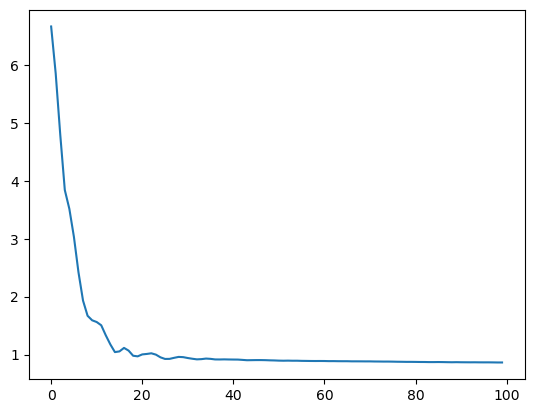

In [204]:
plt.plot(losses)
plt.show()

In [205]:
embedding = model.encode(data).detach().numpy()
embedding.shape

(84592, 64)

In the original L2G code, there is a Patch class handling patches.

###  <a id='chapter3'> <font color="grey">3. Visualisation </font></a>

In [207]:
most_common = ['AU', 'BR', 'CN', 'DE', 'IN', 'ID', 'PL', 'RU', 'GB', 'US']
countries = dl.get_nodes(ts=dates[0])['country'].to_list()
indices = [i for i in range(len(countries)) if countries[i] in most_common]

In [208]:
points = embedding[indices, :]
labels = [most_common.index(countries[i]) for i in indices]

In [209]:
# Use UMAP to visualise the graph embeddings for different days
reducer = umap.UMAP(n_neighbors=5, min_dist=0.0, metric='euclidean')

In [210]:
#points = StandardScaler().fit_transform(points)

In [211]:
umap_embedding = reducer.fit_transform(points)

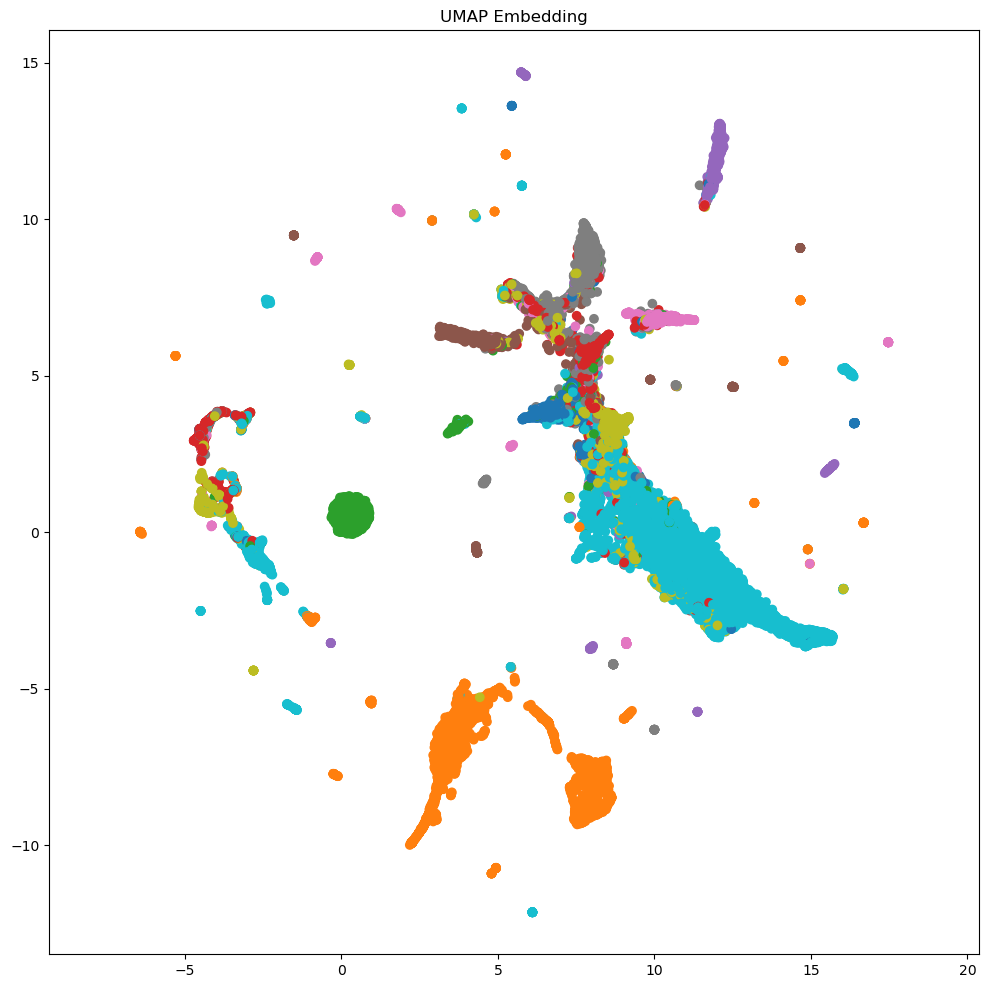

In [212]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=[sns.color_palette()[x] for x in labels],
    lw=1
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Embedding', fontsize=12)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=[sns.color_palette()[x] for x in labels],
    lw=1
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Embedding', fontsize=12)
plt.show()

In [225]:
#patch_list = []
models = []
embeddings = []
for d in dates:
    patch = tg_graphs[d]
    model = VGAE(encoder=Encoder(64, patch.num_node_features))
    model, _ = train(patch, model, VGAE_loss, num_epochs=60, lr=0.01)
    #coordinates = model.encode(patch).detach().numpy()
    models.append(model)

  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.6869659423828125
epoch 20: loss=0.9800000190734863
epoch 40: loss=0.9203616976737976


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.630638122558594
epoch 20: loss=0.9954043030738831
epoch 40: loss=0.9104728698730469


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.63962984085083
epoch 20: loss=1.0162502527236938
epoch 40: loss=0.9115071892738342


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.614290714263916
epoch 20: loss=1.0374518632888794
epoch 40: loss=0.9222940802574158


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.577421188354492
epoch 20: loss=0.9769209623336792
epoch 40: loss=0.9152624011039734


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.683586120605469
epoch 20: loss=1.0189181566238403
epoch 40: loss=0.9161844253540039


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.644247055053711
epoch 20: loss=0.9721484184265137
epoch 40: loss=0.9157313704490662


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.728312015533447
epoch 20: loss=0.9715072512626648
epoch 40: loss=0.910649299621582


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.632400989532471
epoch 20: loss=0.9854189157485962
epoch 40: loss=0.9114165306091309


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.7061638832092285
epoch 20: loss=0.9885604977607727
epoch 40: loss=0.9121685028076172


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.627525806427002
epoch 20: loss=1.0030969381332397
epoch 40: loss=0.911323606967926


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.655829429626465
epoch 20: loss=1.0012050867080688
epoch 40: loss=0.911458432674408


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.698610782623291
epoch 20: loss=1.0307064056396484
epoch 40: loss=0.9103161692619324


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.657337188720703
epoch 20: loss=1.0208884477615356
epoch 40: loss=0.9109532833099365


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.639815807342529
epoch 20: loss=0.9893207550048828
epoch 40: loss=0.9105575084686279


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.687967300415039
epoch 20: loss=1.0075132846832275
epoch 40: loss=0.9048051238059998


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.7059149742126465
epoch 20: loss=0.9793568253517151
epoch 40: loss=0.9147732853889465


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.7688212394714355
epoch 20: loss=0.9900588393211365
epoch 40: loss=0.9102033972740173


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.646402359008789
epoch 20: loss=0.9859020709991455
epoch 40: loss=0.9012864232063293


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.611202239990234
epoch 20: loss=0.988412618637085
epoch 40: loss=0.9090248942375183


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.662230014801025
epoch 20: loss=0.9857534766197205
epoch 40: loss=0.9095436334609985


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.68632173538208
epoch 20: loss=1.0261250734329224
epoch 40: loss=0.9166969656944275


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.5636372566223145
epoch 20: loss=1.0185015201568604
epoch 40: loss=0.9142633676528931


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.741844654083252
epoch 20: loss=1.0030468702316284
epoch 40: loss=0.9235710501670837


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.694669246673584
epoch 20: loss=1.0313485860824585
epoch 40: loss=0.9282753467559814


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.6670966148376465
epoch 20: loss=1.0154666900634766
epoch 40: loss=0.9093332290649414


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.546990394592285
epoch 20: loss=1.0056602954864502
epoch 40: loss=0.9118266105651855


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.693549156188965
epoch 20: loss=1.0408482551574707
epoch 40: loss=0.9187832474708557


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.623946666717529
epoch 20: loss=0.9834305644035339
epoch 40: loss=0.9100981950759888


  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0: loss=6.655704975128174
epoch 20: loss=0.996372640132904
epoch 40: loss=0.9094549417495728


In [247]:
def reduce_data(data, date, most_common):
    countries = dl.get_nodes(ts=date)['country'].to_list()
    indices = [i for i in range(len(countries)) if countries[i] in most_common]
    points = data[indices, :]
    labels = [most_common.index(countries[i]) for i in indices]
    return points, labels

In [248]:
def create_plot(umap_embedding, labels, p):
    fig, ax = plt.subplots(1, 1, figsize=(12,12))
    ax.scatter(
        umap_embedding[p][:, 0],
        umap_embedding[p][:, 1],
        c=[sns.color_palette()[x] for x in labels[p]],
        lw=1
    )
    return fig

In [249]:
reducer = umap.UMAP(n_neighbors=5, min_dist=0.0, metric='euclidean')

In [250]:
embeddings = []
for i,d in enumerate(dates):
    patch = tg_graphs[d]
    embeddings.append(models[i].encode(patch).detach().numpy())

In [264]:
def create_umap(points, reducer):
    return reducer.fit(points)

In [267]:
reducer = umap.UMAP(n_neighbors=5, min_dist=0.0, metric='euclidean')
reducer.fit_transform(embeddings[0], dates[0], most_common)

ValueError: force_all_finite should be a bool or "allow-nan". Got ['AU', 'BR', 'CN', 'DE', 'IN', 'ID', 'PL', 'RU', 'GB', 'US'] instead

In [254]:
points = []
labels = []
umaps = []
for i,d in enumerate(dates):
    p, l = reduce_data(embeddings[i], d, most_common)
    points.append(p)
    labels.append(l)
    umaps.append(create_umap(p, reducer))

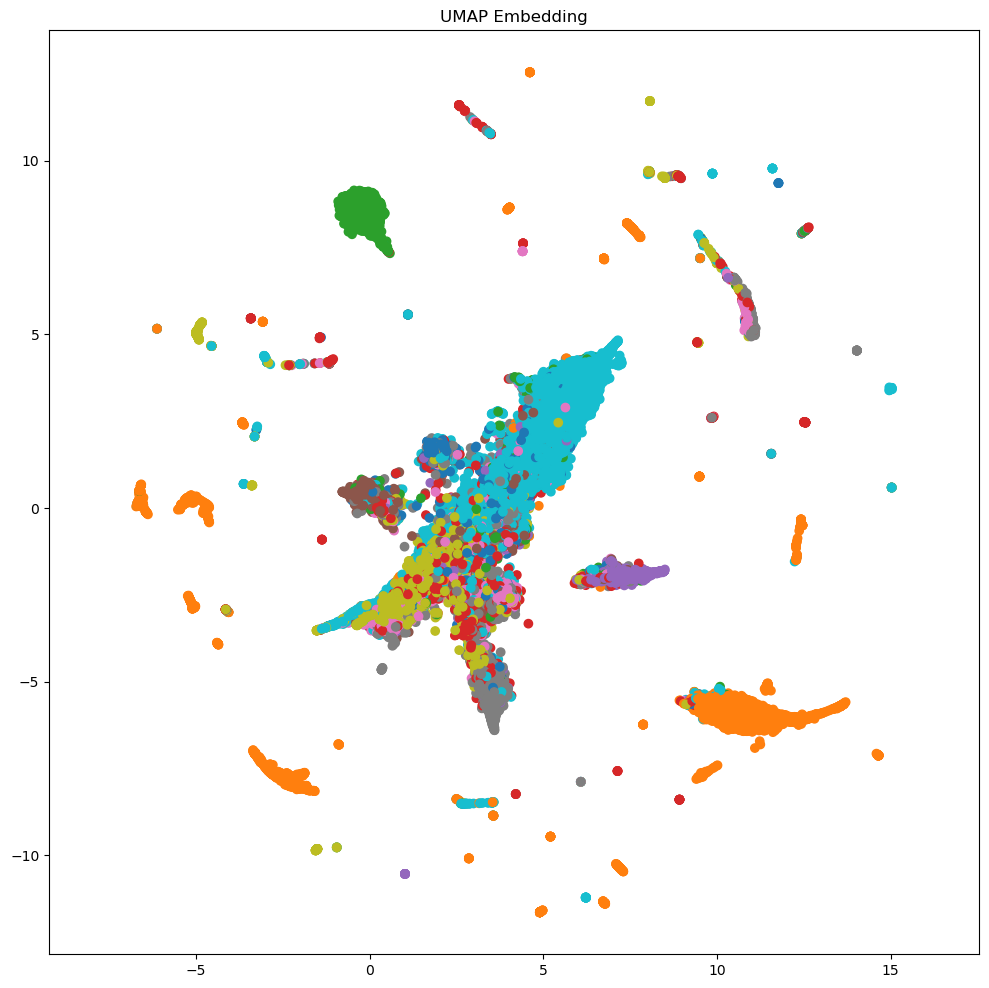

In [255]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(
    umaps[1][:, 0],
    umaps[1][:, 1],
    c=[sns.color_palette()[x] for x in labels[1]],
    lw=1
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Embedding', fontsize=12)
plt.show()

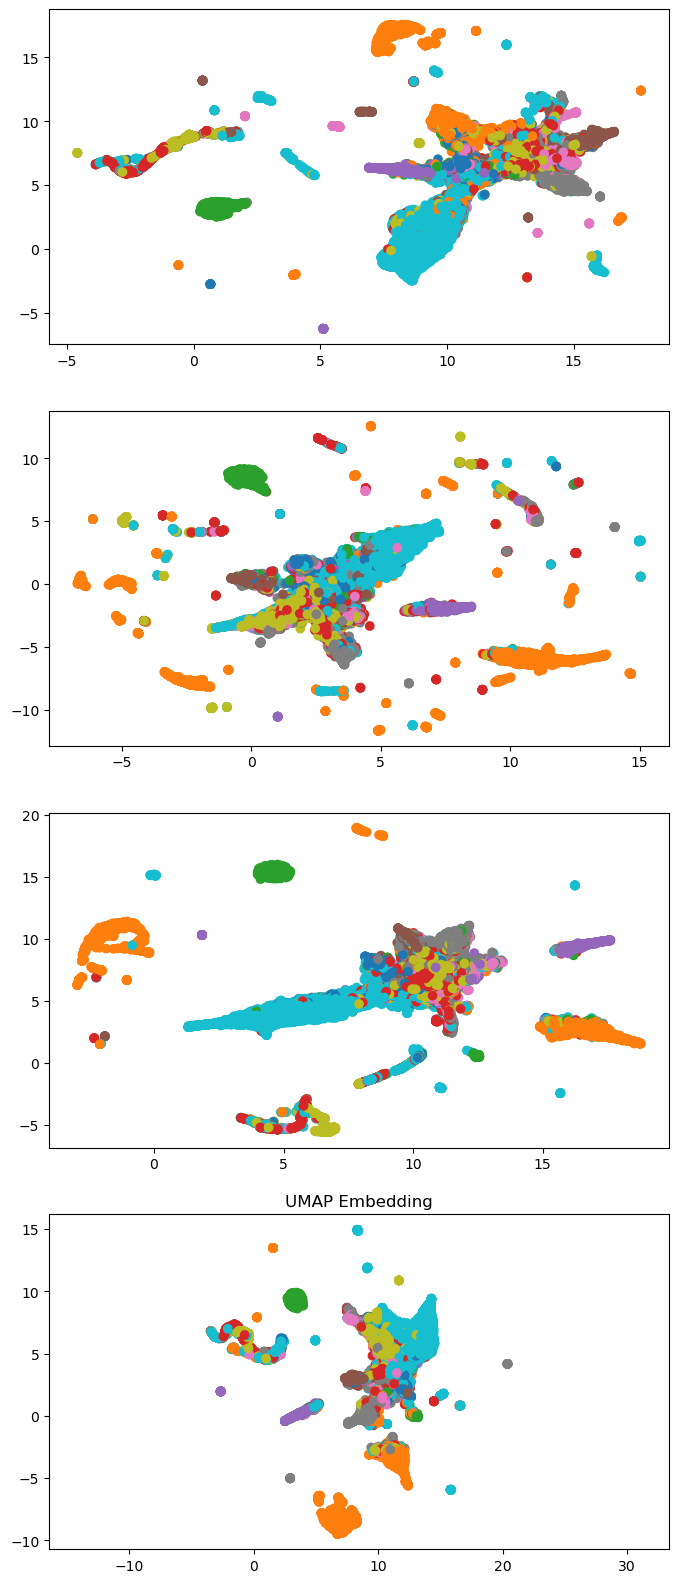

In [263]:
fig, ax = plt.subplots(4, 1, figsize=(8,20))
for i in range(4):
    ax[i].scatter(
        umaps[i][:, 0],
        umaps[i][:, 1],
        c=[sns.color_palette()[x] for x in labels[i]],
        lw=1
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Embedding', fontsize=12)
plt.show()